# 🤖 3 Training the forecasting model

### 🎯 Objective
The objective of this notebook is to include the needed code to train a forecasting model with the tools you find more suitable for the exercise.
You'll be guided through the notebook, but feel free to add anything you may find interesting to add value to the trained model and its accuracy.

### 🔙 Prerrequisites
1. Make sure you have built and transformed the dataset in previous steps, you'll find notebooks guiding you through this process in this same repository.
2. Install any dependencies you may need, using any dependency manager you like.

### 🏁 When you finish
Make sure to comment with markdown cells what you have developed to solve this problem. Also, try to explain how to use your code, what we need to install to use it, etc.

## 1. 🔍 Data Loading

Use this part of the notebook to work on: loading the built dataset and splitting in train, validation and test partitions if desired.

### 1.1 💾 Load the dataset.csv file you built in previous steps

In [50]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import shap
import pickle



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
#from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
sales_df = pd.read_csv('../data/Sales_ipc_calendar_dataset.csv')
sales_df.head()

,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY,Year,Month,DayOfWeek,YearMonth,IPC_VALUE,A,FA,FM,C,CR
0,2015-01-01,1.103868e+03,1.103868e+03,False,2015,1,3,2015-01,-0.4,0,0,0,1521,0
1,2015-01-02,1.317074e+07,1.317184e+07,False,2015,1,4,2015-01,-0.4,1508,0,0,13,0
2,2015-01-03,1.616656e+07,2.933840e+07,False,2015,1,5,2015-01,-0.4,1521,0,0,0,0
3,2015-01-04,1.267257e+05,2.946512e+07,False,2015,1,6,2015-01,-0.4,0,10,0,1511,0
4,2015-01-05,1.791498e+07,4.738010e+07,False,2015,1,0,2015-01,-0.4,1520,0,0,1,0


In [3]:
#missing_data = sales_df.isnull().sum()
#print("Missing values per column:\n", missing_data)
sales_df['HOLIDAY'] = sales_df['HOLIDAY'].astype(bool)
#print(sales_df.dtypes)

### 1.2 ✂️ Split your data in partitions

In [4]:
# Target (y) and Featurews(X)
X = sales_df.drop(columns=['SALES'])
y = sales_df['SALES']

To implement time series splitting for our forecasting model, it is important to split the data in a way that respects the temporal order, ensuring that future data is never used to train the model. One method commonly used for this is `TimeSeriesSplit` from scikit-learn, which ensures that each split contains past data and leaves future data for testing.

In [5]:
# Set up time series split (e.g., with 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

Each iteration of the split will provide a larger portion of the past data for training and reserve a portion of the future data for validation.

For each split, we can train our model on the training set and validate it on the validation set.

In [6]:
# Visualize or print the indices of the train/test splits
for train_index, test_index in tscv.split(X):
    #print("\n \n \n TRAIN:", train_index, "\n \nTEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## 2. 🎯 Feature Selection

Here, you may find useful to select the features you will use for training and the target to forecast. Try to explain why you have selected these features and discarded others.

Remember that the sales column you can find in `data/sales_train_dataset.csv` should be the target variable for your model.

**Correlation study**

By calculating the correlations between each variable and `SALES`, we can see which features have the strongest linear relationship with the target.

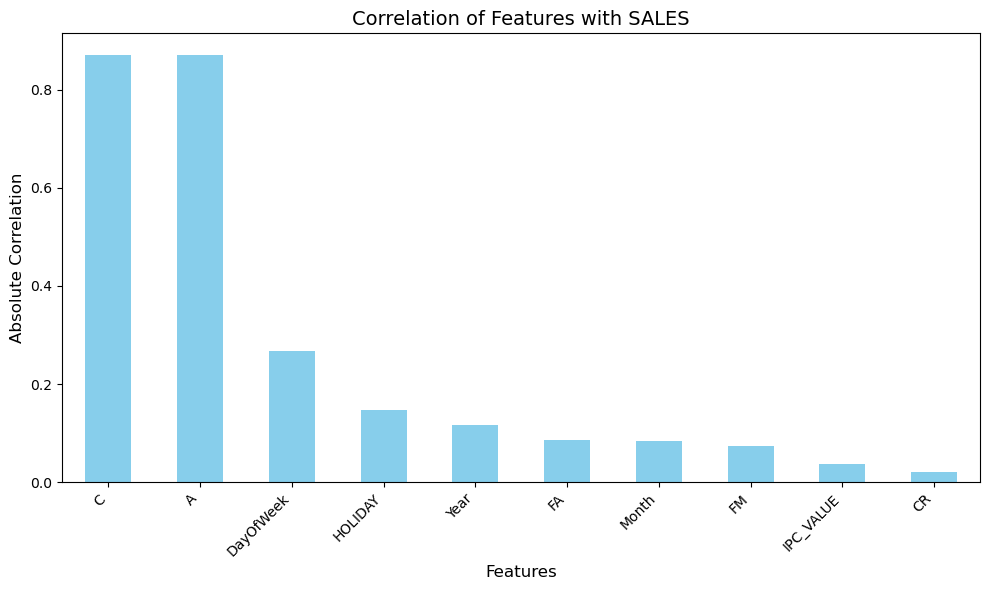

In [7]:
numeric_features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 'IPC_VALUE', 'A', 'FA', 'FM', 'C', 'CR']
correlation_matrix = sales_df[numeric_features + ['SALES']].corr()
correlation_with_sales = correlation_matrix['SALES'].drop('SALES')
correlation_with_sales_sorted = correlation_with_sales.abs().sort_values(ascending=False)
#print(correlation_with_sales_sorted)

plt.figure(figsize=(10, 6))
correlation_with_sales_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with SALES', fontsize=14)
plt.xlabel('Features', fontsize=12)

plt.ylabel('Absolute Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

| Rank | Feature     | Correlation |
|------|-------------|-------------|
| 1    | C           | 0.871395    |
| 2    | A           | 0.870674    |
| 3    | DayOfWeek   | 0.267554    |
| 4    | HOLIDAY     | 0.147047    |
| 5    | Year        | 0.116122    |
| 6    | FA          | 0.086449    |
| 7    | Month       | 0.082997    |
| 8    | FM          | 0.073669    |
| 9    | IPC_VALUE   | 0.037194    |
| 10   | CR          | 0.019965    |


It is logical that the number of open or closed stores ranks highest in importance, as it directly impacts whether customers can make purchases. The day of the week also plays a significant role, with Saturdays showing a marked increase in sales compared to other days.

Now it would be necessary to study the autocorrelations since they can provide redundant information to the model, and in many cases, one of them can be removed without significantly affecting model performance. This process helps reduce model complexity and avoid multicollinearity issues, which can cause unstable or less interpretable models.

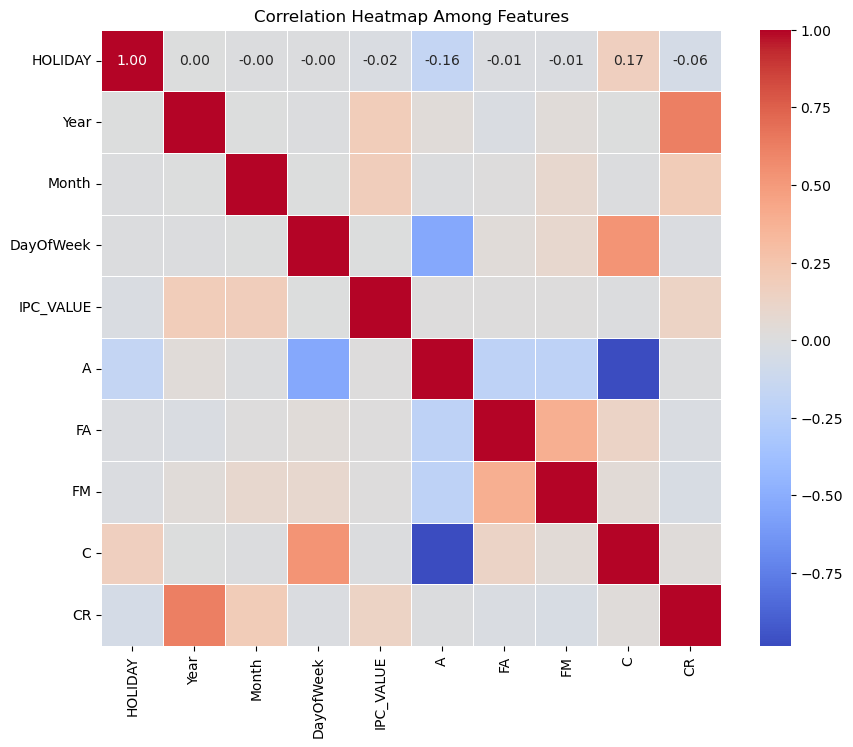

In [8]:
correlation_matrix = sales_df[numeric_features].corr()

# Plot a heatmap of the correlation matrix with numbers in all cells
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap Among Features')
plt.show()

# Identify highly correlated pairs (absolute value > 0.8)
highly_correlated = correlation_matrix.abs() > 0.8
highly_correlated_pairs = correlation_matrix[highly_correlated & (correlation_matrix != 1)]

#print("Highly Correlated Pairs:")
#print(highly_correlated_pairs)

As anticipated, the heatmap reveals a strong negative correlation between `A` (open stores) and `C` (closed stores), which makes sense given that these features represent mutually exclusive states. 

When a feature is constant or exhibits minimal variance, its correlation with other features will often result in `NaN` values. This occurs because correlation is undefined for variables with zero or near-zero variance. This is likely the cause of the `NaN` values observed when examining the `highly_correlated_pairs`, as some features may have little or no variability in the dataset. Addressing these features, such as by removing or transforming them, could resolve the issue.

Removing `CR` and `FM` because of its low relevance.

Removing `C`because of its high correlation with `A`.

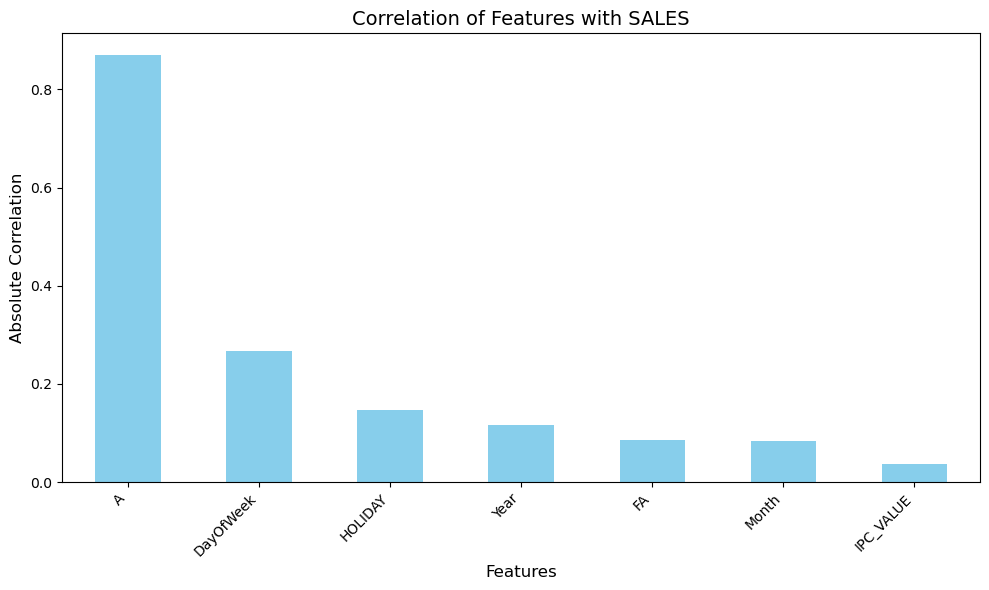

In [9]:
numeric_features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 'IPC_VALUE', 'A', 'FA']
correlation_matrix = sales_df[numeric_features + ['SALES']].corr()
correlation_with_sales = correlation_matrix['SALES'].drop('SALES')
correlation_with_sales_sorted = correlation_with_sales.abs().sort_values(ascending=False)
#print(correlation_with_sales_sorted)

plt.figure(figsize=(10, 6))
correlation_with_sales_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with SALES', fontsize=14)
plt.xlabel('Features', fontsize=12)

plt.ylabel('Absolute Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

<!--
The [autocorrelation_plot](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) is a commonly used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelation for data values at varying time lags. 


#autocorrelation_plot(sales_df['SALES'])
#plt.show()

-->

### Other ideas

#### Lagged features

Let's explore adding lagged sales features, as these as they often carry strong predictive power for future sales in time series forecasting.

In [10]:
# Create lagged sales features
sales_lag_df = sales_df.copy()

sales_lag_df['lag_1'] = sales_lag_df['SALES'].shift(1)   # Lag by 1 day
sales_lag_df['lag_7'] = sales_lag_df['SALES'].shift(7)   # Lag by 7 days (1 week)

sales_lag_df = sales_lag_df.dropna()

#sales_lag_df[['SALES', 'lag_1', 'lag_7']].head(14)

#### Deterring

Detrending removes the long-term growth or decline in the data. This is important because it helps isolate the patterns that are independent of the long-term upward or downward trend.

see [Time Series Feature Selection: Which Methods to Apply](https://medium.com/@saverio3107/time-series-feature-selection-which-methods-to-apply-ec2b6aa57bef)

<!--
```
# Detrend by differencing
sales_lag_df['sales_detrended'] = sales_lag_df['SALES'].diff()

# Drop the first NaN value caused by differencing
sales_lag_df.dropna(inplace=True)

# Verify the detrended sales
print(sales_lag_df[['SALES', 'sales_detrended']].head())
```

Note: Turned off by now
-->

In [11]:
# Detrend by differencing
sales_lag_df['sales_detrended'] = sales_lag_df['SALES'].diff()

# Drop the first NaN value caused by differencing
sales_lag_df.dropna(inplace=True)

# Verify the detrended sales
print(sales_lag_df[['SALES', 'sales_detrended']].head())

           SALES  sales_detrended
8   1.442774e+07     2.070327e+06
9   1.830662e+07     3.878875e+06
10  7.223293e+04    -1.823438e+07
11  1.238362e+07     1.231138e+07
12  1.075283e+07    -1.630791e+06


<!--
#### Deseasonalizing

Deseasonalizing removes the seasonal patterns (e.g., weekly, monthly) from the data. This allows the model to focus on underlying trends and avoid overfitting to seasonal fluctuations.

```
sales_lag_df['DATE'] = pd.to_datetime(sales_lag_df['DATE'])

# Set the DATE column as the index and fill missing dates with daily frequency
sales_lag_df = sales_lag_df.set_index('DATE').asfreq('D')  # 'D' stands for daily frequency

# Apply STL decomposition with an appropriate seasonal period (e.g., 7 for weekly seasonality)
stl = STL(sales_lag_df['SALES'], seasonal=7)
result = stl.fit()

# Deseasonalized sales
sales_lag_df['sales_deseasonalized'] = sales_lag_df['SALES'] - result.seasonal

# Verify the deseasonalized sales
print(sales_lag_df[['SALES', 'sales_deseasonalized']].head())
```
-->

In [12]:
#sales_lag_df.head()

#### RandomForestRegressor for Feature Selection

Although `RandomForestRegressor` is not designed for time series forecasting, it is highly effective for feature selection. It ranks features by importance, helping determine how much each contributes to the prediction task. 
<!--
This method is valuable because it:

- **Captures nonlinear relationships** between features and the target variable.
- **Accounts for feature interactions**, which might be missed by simpler statistical methods.
- **Does not require stationarity**, unlike traditional time series models like ARIMA.
-->
By using `RandomForest`, we can rank both time-based features (e.g., lagged features) and categorical variables (e.g., `DayOfWeek`). The most relevant features can then be used in time-series-specific models like ARIMA, Prophet, or LSTM for better forecasting performance.

In [13]:
features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 
            'IPC_VALUE', 'A', 'FA','lag_1', 'lag_7']
            #,'FM', 'C', 'CR']
            #'sales_deseasonalized', 'sales_detrended']  # left out 

X = sales_lag_df[features]
y = sales_lag_df['SALES']

# Train Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Display feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features)
#feature_importance.sort_values(ascending=False)

| Feature    | Importance Value  |
|------------|-------------------|
| A          | 0.7593            |
| DayOfWeek  | 0.1194            |
| lag_7      | 0.0534            |
| lag_1      | 0.0434            |
| FA         | 0.0107            |
| Month      | 0.0075            |
| Year       | 0.0036            |
| IPC_VALUE  | 0.0028            |
| HOLIDAY    | 0.0000000212      |

<!--
1. **A (Open)**:
   - Being the most important feature, this suggests that whether the store is open or closed has the strongest influence on sales.
   
2. **DayOfWeek**:
   - Sales behavior changes by the day of the week, as previously analyzed, with Saturdays generally showing the highest sales.

3. **Lag Features (lag_7 and lag_1)**:
   - These show that past sales data from one week ago (`lag_7`) and one day ago (`lag_1`) provide relevant information for forecasting sales. This is common in time series data, where historical values have predictive power.

4. **FA (Open on holiday)**:
   - This shows that being open on a holiday provides a minor contribution to predicting sales. It is less important than general open/closed status.

5. **Month and Year**:
   - These capture broader seasonality and year-over-year trends, but their impact is minimal compared to the other features.

6. **IPC_VALUE (Inflation)**:
   - The inflation value (`IPC_VALUE`) has some predictive power but is not very significant in daily sales predictions.

7. **HOLIDAY**:
   - This feature has almost no influence on predicting sales, potentially because other variables (such as `FA` and `A`) already capture the holiday effects.
-->

`RandomForestRegressor` effectively ranked the features by importance, identifying key predictors such as store open status (`A`), day of the week, and lagged sales data. These features are critical in forecasting sales.

The final set of features is:

In [14]:
features = ['A'
            , 'DayOfWeek'
            , 'lag_1'
            , 'lag_7'
            , 'FA'
            , 'Month'
            , 'Year'
           ] 

## 3. 🤖 Modeling

In this section you will declare everything you need to train your model and fit it to your dataset.

When using cross-validation (like `TimeSeriesSplit`),it is not necessary a separate validation set, since each fold in cross-validation acts as both validation and training at different stages.

However, we could manually split the time data doing the following:
```
train_size = int(len(sales_lag_df) * 0.7)        # 70% training
validation_size = int(len(sales_lag_df) * 0.15)  # 15% validation
test_size = len(sales_lag_df) - train_size - validation_size  # 15% test

train_df = sales_lag_df.iloc[:train_size]
validation_df = sales_lag_df.iloc[train_size:train_size + validation_size]
test_df = sales_lag_df.iloc[train_size + validation_size:]

X_train, y_train = train_df.drop(columns=['SALES']), train_df['SALES']
X_val, y_val = validation_df.drop(columns=['SALES']), validation_df['SALES']
X_test, y_test = test_df.drop(columns=['SALES']), test_df['SALES']
```
Note that for time series data, we don't want to randomize the splits because preserving the temporal order is crucial.


We will stick to cross-validation

### 3.1 Prophet
Simple model for forecasting

```
prophet_df = sales_lag_df[['DATE', 'SALES']].rename(columns={'DATE': 'ds', 'SALES': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)  # Forecast 30 days ahead
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
```


### 3.2 ARIMA (AutoRegressive Integrated Moving Average)
Statistical model that captures the dependencies in time series data. A priori, this can be the best choice since it works well for univariate forecasting tasks (like predicting `SALES` over time).

**ADF**

The Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or not. Stationarity is an important assumption for many time series models, including ARIMA. If the p-value of the ADF test is below a certain threshold (e.g., 0.05), you can reject the null hypothesis that the series has a unit root, indicating that the series is stationary.

In [15]:
def perform_adfuller_test(series, column_name):

    result = adfuller(series)

    print(f"ADF Test for {column_name}:")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    # Interpret the p-value
    if result[1] < 0.05:
        print(f"The {column_name} series is stationary (reject the null hypothesis).\n")
    else:
        print(f"The {column_name} series is not stationary (fail to reject the null hypothesis).\n")

In [16]:
perform_adfuller_test(sales_lag_df['SALES'], 'SALES')

ADF Test for SALES:
ADF Statistic: -2.5503603584929713
p-value: 0.10369679262560683
Critical Values:
   1%: -3.4349343845870006
   5%: -2.8635646903561653
   10%: -2.5678479326174157
The SALES series is not stationary (fail to reject the null hypothesis).



This is relevant since ARIMA assumes the data is stationary. 

By using `sales_detrended`instead of `SALES`, we have stationary data. This means that we can proceed using ARIMA model without further tranformations to make data stationary.

In [17]:
perform_adfuller_test(sales_lag_df['sales_detrended'], 'sales_detrended')

ADF Test for sales_detrended:
ADF Statistic: -15.490282571499169
p-value: 2.4900079227518523e-28
Critical Values:
   1%: -3.434931172941245
   5%: -2.8635632730206857
   10%: -2.567847177857108
The sales_detrended series is stationary (reject the null hypothesis).



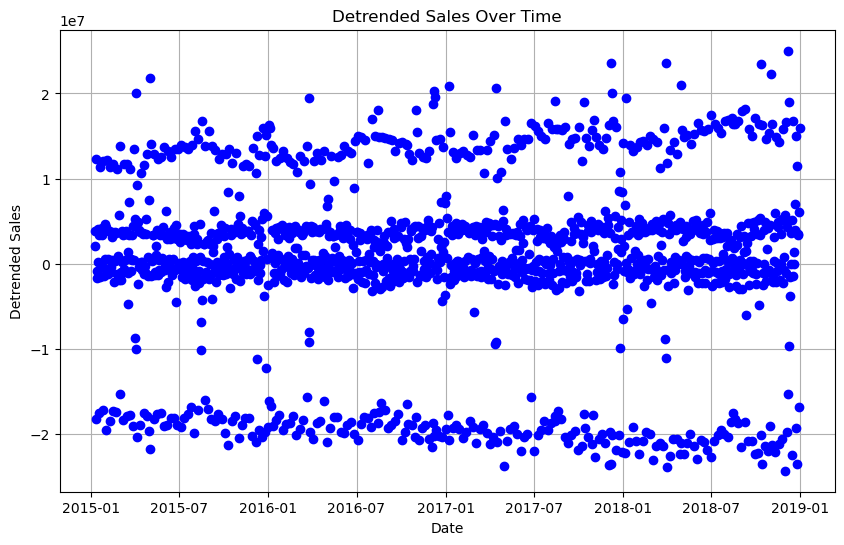

In [18]:
sales_lag_dff = sales_lag_df.copy()
sales_lag_dff['DATE'] = pd.to_datetime(sales_lag_dff['DATE'])
sales_lag_dff.set_index('DATE', inplace=True)

# Plot sales_detrended vs date
plt.figure(figsize=(10, 6))
plt.plot(sales_lag_dff.index, sales_lag_dff['sales_detrended'], color='blue',linestyle='None', marker='o')
plt.title('Detrended Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Detrended Sales')
plt.grid(True)
plt.show()

Differencing has already been applied to `sales_detrended`, so we use this detrended data for the ARIMA model instead of `SALES`

Applying `TimeSeriesSplit`for Cross-Validation

In [19]:
print(f"Features: {features}")

sales_lag_df['DATE'] = pd.to_datetime(sales_lag_df['DATE'], errors='coerce')
sales_lag_df.set_index('DATE', inplace=True)
sales_lag_df = sales_lag_df.asfreq('D')

X = sales_lag_df[features] 
#y = sales_lag_df['SALES']
y = sales_lag_df['sales_detrended']  # differentitated target


tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Features: ['A', 'DayOfWeek', 'lag_1', 'lag_7', 'FA', 'Month', 'Year']

X_train shape: (243, 7), X_test shape: (242, 7)
y_train shape: (243,), y_test shape: (242,)

X_train shape: (485, 7), X_test shape: (242, 7)
y_train shape: (485,), y_test shape: (242,)

X_train shape: (727, 7), X_test shape: (242, 7)
y_train shape: (727,), y_test shape: (242,)

X_train shape: (969, 7), X_test shape: (242, 7)
y_train shape: (969,), y_test shape: (242,)

X_train shape: (1211, 7), X_test shape: (242, 7)
y_train shape: (1211,), y_test shape: (242,)


We can build an ARIMA model on each training set and evaluate its performance on the corresponding test set.

It is necessary to choose the $d$, $p$ and $q$ for the ARIMA model. This model combines Auto Regression(AR), Moving Average(MA) and differencing(I). Equations below show the meaning of $p$ and $q$.


- Autoregression AR($p$): $y_t = \alpha + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \beta_3 y_{t-3} + \dots + \beta_{p} y_{t-p}$

- Moving average MA($q$): $y_t = \mu + \epsilon_{t} + \omega_{1} \epsilon_{t-1} + \omega_{2} \epsilon_{t-2} + \omega_{3} \epsilon_{t-3} + \dots + \omega_{q} \epsilon_{t-q}$

- ARMA($p,q$): $y_t = \alpha + \epsilon_{t} + \sum_{i=1}^{p} \beta_i y_{t-i} + \sum_{j=1}^{q} \omega_j \epsilon_{t-j}$


Since we have differenciated our data once, we can set `d=0`.

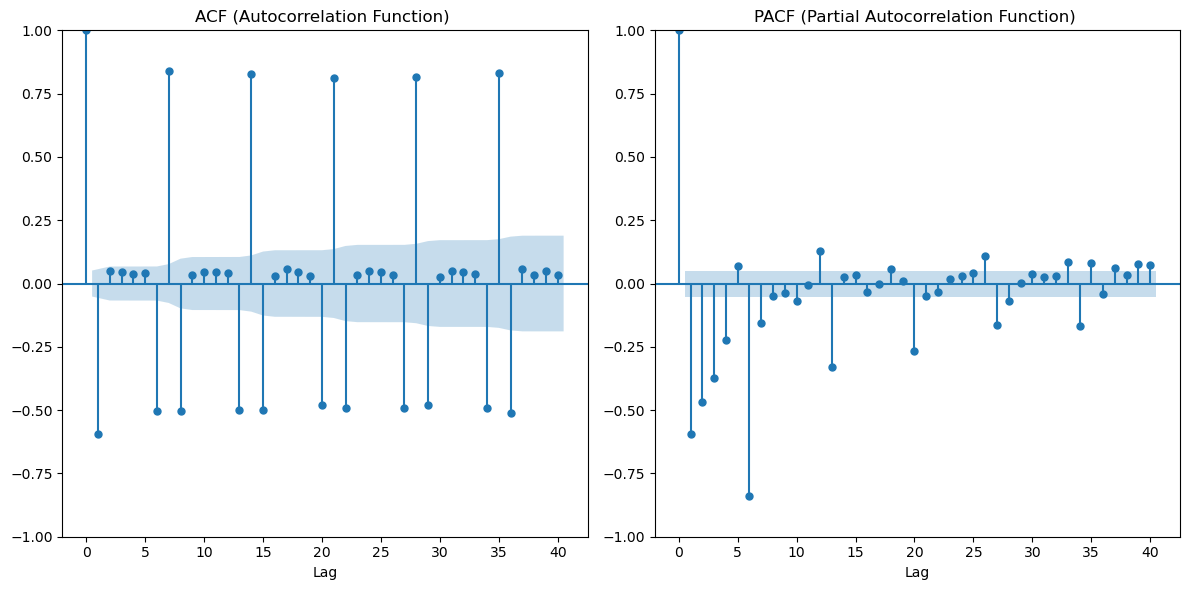

In [20]:
def plot_acf_pacf(time_series, title_suffix=''):
    plt.figure(figsize=(12, 6))

    # Plot ACF (for choosing q)
    plt.subplot(121)
    plot_acf(time_series, lags=40, ax=plt.gca())
    plt.title(f'ACF (Autocorrelation Function) {title_suffix}')
    plt.xlabel('Lag')

    # Plot PACF (for choosing p)
    plt.subplot(122)
    plot_pacf(time_series, lags=40, ax=plt.gca())
    plt.title(f'PACF (Partial Autocorrelation Function) {title_suffix}')
    plt.xlabel('Lag')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(sales_lag_df['sales_detrended'])

In [33]:
def evaluate_arima_model_on_scaled(X, y, p, d, q, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scaler = StandardScaler()
    
    mse_values_scaled = []
    mae_values_scaled = []
    rmse_values_scaled = []
    mape_values_scaled = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        # Make sure to use .iloc[] to properly index the DataFrames
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the target variable (y) - training and testing sets
        y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

        # Build and fit the ARIMA model
        model = ARIMA(y_train_scaled, order=(p, d, q))
        model_fit = model.fit()

        # Forecast directly on the scaled data
        y_pred_scaled = model_fit.forecast(steps=len(y_test_scaled))

        # Calculate evaluation metrics on the scaled data
        mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
        mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
        rmse_scaled = np.sqrt(mse_scaled)
        mape_scaled = np.mean(np.abs((y_test_scaled - y_pred_scaled) / y_test_scaled)) * 100  # MAPE in %

        mse_values_scaled.append(mse_scaled)
        mae_values_scaled.append(mae_scaled)
        rmse_values_scaled.append(rmse_scaled)
        mape_values_scaled.append(mape_scaled)

        #print(f"Fold {fold}: MAE (scaled)={mae_scaled:.4f}, MSE (scaled)={mse_scaled:.4f}, RMSE (scaled)={rmse_scaled:.4f}, MAPE (scaled)={mape_scaled:.2f}%")

    # Calculate and return the average MSE, MAE, RMSE, and MAPE on the scaled scale
    average_mae_scaled = np.mean(mae_values_scaled)
    average_mse_scaled = np.mean(mse_values_scaled)
    average_rmse_scaled = np.mean(rmse_values_scaled)
    average_mape_scaled = np.mean(mape_values_scaled)

    print(f"\nConfig({p}, {d}, {q}) --> Average MAE (scaled): {average_mae_scaled}")

    return average_mae_scaled, average_mse_scaled, average_rmse_scaled, average_mape_scaled


In [34]:
# Grid search ARIMA hyperparameters (p, d, q)
p_values = [0, 1, 2, 5, 7, 9]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2]

best_mae_scaled = float('inf')
best_order_scaled = None

best_mae_scaled = float('inf')
best_mse_scaled = float('inf')
best_rmse_scaled = float('inf')
best_mape_scaled = float('inf')

print("ARIMA :: Using sales_detrended (scaled metrics)")

# Grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            print(f"Evaluating ARIMA({p}, {d}, {q})")
            # Get all metrics: MAE, MSE, RMSE, MAPE
            average_mae_scaled, average_mse_scaled, average_rmse_scaled, average_mape_scaled = evaluate_arima_model_on_scaled(X, y, p, d, q)
            
            # Compare the average MAE across all folds
            if average_mae_scaled < best_mae_scaled:
                best_mae_scaled = average_mae_scaled
                best_order_scaled = (p, d, q)
                # Store all the best metrics
                best_mse_scaled = average_mse_scaled
                best_rmse_scaled = average_rmse_scaled
                best_mape_scaled = average_mape_scaled

# Print the best result
print(f"\n\nBest ARIMA order for detrended sales (scaled metrics) based on MAE: {best_order_scaled}")
print(f"Average MAE: {best_mae_scaled}")
print(f"Average MSE: {best_mse_scaled}")
print(f"Average RMSE: {best_rmse_scaled}")
print(f"Average MAPE: {best_mape_scaled}%")

ARIMA :: Using sales_detrended (scaled metrics)
Evaluating ARIMA(0, 0, 0)

Config(0, 0, 0) --> Average MAE (scaled): 0.8291655780261233
Evaluating ARIMA(0, 0, 1)

Config(0, 0, 1) --> Average MAE (scaled): 0.828560212449813
Evaluating ARIMA(0, 0, 2)

Config(0, 0, 2) --> Average MAE (scaled): 0.8289684457898046
Evaluating ARIMA(0, 1, 0)

Config(0, 1, 0) --> Average MAE (scaled): 1.1830325620192945
Evaluating ARIMA(0, 1, 1)

Config(0, 1, 1) --> Average MAE (scaled): 0.8085650722067108
Evaluating ARIMA(0, 1, 2)

Config(0, 1, 2) --> Average MAE (scaled): 0.7868506759276411
Evaluating ARIMA(0, 2, 0)

Config(0, 2, 0) --> Average MAE (scaled): 122.71735675158293
Evaluating ARIMA(0, 2, 1)

Config(0, 2, 1) --> Average MAE (scaled): 1.3402860838855153
Evaluating ARIMA(0, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Config(0, 2, 2) --> Average MAE (scaled): 8.91217661090877
Evaluating ARIMA(0, 3, 0)

Config(0, 3, 0) --> Average MAE (scaled): 21660.504047987648
Evaluating ARIMA(0, 3, 1)

Config(0, 3, 1) --> Average MAE (scaled): 142.80905229563876
Evaluating ARIMA(0, 3, 2)

Config(0, 3, 2) --> Average MAE (scaled): 19.352647477991674
Evaluating ARIMA(1, 0, 0)

Config(1, 0, 0) --> Average MAE (scaled): 0.8286555142134933
Evaluating ARIMA(1, 0, 1)

Config(1, 0, 1) --> Average MAE (scaled): 0.8289445629509901
Evaluating ARIMA(1, 0, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para


Config(1, 0, 2) --> Average MAE (scaled): 0.8275911403092449
Evaluating ARIMA(1, 1, 0)

Config(1, 1, 0) --> Average MAE (scaled): 0.9488278070591656
Evaluating ARIMA(1, 1, 1)

Config(1, 1, 1) --> Average MAE (scaled): 0.8006693370970354
Evaluating ARIMA(1, 1, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para


Config(1, 1, 2) --> Average MAE (scaled): 0.7872574349650081
Evaluating ARIMA(1, 2, 0)

Config(1, 2, 0) --> Average MAE (scaled): 110.15188779472825
Evaluating ARIMA(1, 2, 1)

Config(1, 2, 1) --> Average MAE (scaled): 1.0303701112519401
Evaluating ARIMA(1, 2, 2)

Config(1, 2, 2) --> Average MAE (scaled): 3.146493136376769
Evaluating ARIMA(1, 3, 0)

Config(1, 3, 0) --> Average MAE (scaled): 10103.474477059764
Evaluating ARIMA(1, 3, 1)

Config(1, 3, 1) --> Average MAE (scaled): 137.86763889218096
Evaluating ARIMA(1, 3, 2)

Config(1, 3, 2) --> Average MAE (scaled): 10.503466620594384
Evaluating ARIMA(2, 0, 0)

Config(2, 0, 0) --> Average MAE (scaled): 0.8289974816008243
Evaluating ARIMA(2, 0, 1)

Config(2, 0, 1) --> Average MAE (scaled): 0.8289945437404747
Evaluating ARIMA(2, 0, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para


Config(2, 0, 2) --> Average MAE (scaled): 0.827571524735496
Evaluating ARIMA(2, 1, 0)

Config(2, 1, 0) --> Average MAE (scaled): 0.8989988405684194
Evaluating ARIMA(2, 1, 1)

Config(2, 1, 1) --> Average MAE (scaled): 0.7964696868552984
Evaluating ARIMA(2, 1, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para


Config(2, 1, 2) --> Average MAE (scaled): 0.7976643013362514
Evaluating ARIMA(2, 2, 0)

Config(2, 2, 0) --> Average MAE (scaled): 60.75090885672523
Evaluating ARIMA(2, 2, 1)

Config(2, 2, 1) --> Average MAE (scaled): 0.9701235743702867
Evaluating ARIMA(2, 2, 2)

Config(2, 2, 2) --> Average MAE (scaled): 1.031939881254393
Evaluating ARIMA(2, 3, 0)

Config(2, 3, 0) --> Average MAE (scaled): 5849.44351029678
Evaluating ARIMA(2, 3, 1)

Config(2, 3, 1) --> Average MAE (scaled): 76.32241082687713
Evaluating ARIMA(2, 3, 2)

Config(2, 3, 2) --> Average MAE (scaled): 105.18607921569999
Evaluating ARIMA(5, 0, 0)

Config(5, 0, 0) --> Average MAE (scaled): 0.829296840959153
Evaluating ARIMA(5, 0, 1)

Config(5, 0, 1) --> Average MAE (scaled): 0.8295319291138361
Evaluating ARIMA(5, 0, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib


Config(5, 0, 2) --> Average MAE (scaled): 0.838165129306512
Evaluating ARIMA(5, 1, 0)

Config(5, 1, 0) --> Average MAE (scaled): 0.883329910677622
Evaluating ARIMA(5, 1, 1)

Config(5, 1, 1) --> Average MAE (scaled): 0.790155114844031
Evaluating ARIMA(5, 1, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para


Config(5, 1, 2) --> Average MAE (scaled): 0.7897807503015138
Evaluating ARIMA(5, 2, 0)

Config(5, 2, 0) --> Average MAE (scaled): 32.381137538960736
Evaluating ARIMA(5, 2, 1)

Config(5, 2, 1) --> Average MAE (scaled): 0.9285349056135868
Evaluating ARIMA(5, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(5, 2, 2) --> Average MAE (scaled): 0.9526109053655313
Evaluating ARIMA(5, 3, 0)

Config(5, 3, 0) --> Average MAE (scaled): 3600.7269227651095
Evaluating ARIMA(5, 3, 1)

Config(5, 3, 1) --> Average MAE (scaled): 36.35806820440723
Evaluating ARIMA(5, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:


Config(5, 3, 2) --> Average MAE (scaled): 34.84860466217539
Evaluating ARIMA(7, 0, 0)

Config(7, 0, 0) --> Average MAE (scaled): 0.7428530489311533
Evaluating ARIMA(7, 0, 1)

Config(7, 0, 1) --> Average MAE (scaled): 0.7415385068011219
Evaluating ARIMA(7, 0, 2)

Config(7, 0, 2) --> Average MAE (scaled): 0.7396983719562911
Evaluating ARIMA(7, 1, 0)

Config(7, 1, 0) --> Average MAE (scaled): 0.7056474200483814
Evaluating ARIMA(7, 1, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(7, 1, 1) --> Average MAE (scaled): 0.7109213715785616
Evaluating ARIMA(7, 1, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace


Config(7, 1, 2) --> Average MAE (scaled): 0.696743377110234
Evaluating ARIMA(7, 2, 0)

Config(7, 2, 0) --> Average MAE (scaled): 5.286672889621258
Evaluating ARIMA(7, 2, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(7, 2, 1) --> Average MAE (scaled): 0.7043395486184586
Evaluating ARIMA(7, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace


Config(7, 2, 2) --> Average MAE (scaled): 0.7300823785728221
Evaluating ARIMA(7, 3, 0)

Config(7, 3, 0) --> Average MAE (scaled): 600.3564959301616
Evaluating ARIMA(7, 3, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(7, 3, 1) --> Average MAE (scaled): 12.007195655415167
Evaluating ARIMA(7, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(7, 3, 2) --> Average MAE (scaled): 3.5699597355802934
Evaluating ARIMA(9, 0, 0)

Config(9, 0, 0) --> Average MAE (scaled): 0.7412312678104849
Evaluating ARIMA(9, 0, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(9, 0, 1) --> Average MAE (scaled): 0.7385873975498743
Evaluating ARIMA(9, 0, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(9, 0, 2) --> Average MAE (scaled): 0.7318188789933733
Evaluating ARIMA(9, 1, 0)

Config(9, 1, 0) --> Average MAE (scaled): 0.6978189525610171
Evaluating ARIMA(9, 1, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 1, 1) --> Average MAE (scaled): 0.7101348089075584
Evaluating ARIMA(9, 1, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 1, 2) --> Average MAE (scaled): 0.7072554240807312
Evaluating ARIMA(9, 2, 0)

Config(9, 2, 0) --> Average MAE (scaled): 2.717934711308212
Evaluating ARIMA(9, 2, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 2, 1) --> Average MAE (scaled): 0.7154478114731194
Evaluating ARIMA(9, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 2, 2) --> Average MAE (scaled): 0.695365228026424
Evaluating ARIMA(9, 3, 0)

Config(9, 3, 0) --> Average MAE (scaled): 208.64458594835497
Evaluating ARIMA(9, 3, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 3, 1) --> Average MAE (scaled): 7.589815804687376
Evaluating ARIMA(9, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 3, 2) --> Average MAE (scaled): 3.1993039788165207

Best ARIMA order for detrended sales (scaled metrics) based on MAE: (9, 2, 2)
Average MAE: 0.695365228026424
Average MSE: 0.9468756536599043
Average RMSE: 0.9727855974172221
Average MAPE: 380.18950232275483%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA configuration for detrended sales (9, 3, 2) --> Average MAE (scaled): 3.199

| Metric     | Value                     |
|------------|----------------------------|
| ARIMA Order| (9, 2, 2)                  |
| Average MAE| 0.695365228026424          |
| Average MSE| 0.9468756536599043         |
| Average RMSE| 0.9727855974172221        |
| Average MAPE| 380.18950232275483%       |


After making predictions on the detrended data, we can convert them back to the original `SALES` by reversing the differencing process. The key idea is to re-integrate the predicted differences (detrended values) back to the original scale by adding the last actual value from the previous data point.

### 3.3 ARIMA  without detrend
Instead of using detrend, we can set `d=1`.
Then, we can perform a grid search for the best (p, d, q) values

In [58]:
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

In [60]:
X = sales_lag_df[features]
y = sales_lag_df['SALES']

p_values = [2, 5, 7, 9, 12]
d_values = [2, 3]
q_values = [1, 2,4]

best_mse = float('inf')
best_order = None

best_mae_scaled = float('inf')
best_mse_scaled = float('inf')
best_rmse_scaled = float('inf')
best_mape_scaled = float('inf')

print("ARIMA :: Using SALES")

# Grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            print(f"Evaluating ARIMA({p}, {d}, {q})")
            # Get all metrics: MAE, MSE, RMSE, MAPE
            average_mae_scaled, average_mse_scaled, average_rmse_scaled, average_mape_scaled = evaluate_arima_model_on_scaled(X, y, p, d, q)
            
            # Compare the average MAE across all folds
            if average_mae_scaled < best_mae_scaled:
                best_mae_scaled = average_mae_scaled
                best_order_scaled = (p, d, q)
                # Store all the best metrics
                best_mse_scaled = average_mse_scaled
                best_rmse_scaled = average_rmse_scaled
                best_mape_scaled = average_mape_scaled

# Print the best result
print(f"\n\nBest ARIMA order for (not detrended) SALES (scaled metrics) based on MAE: {best_order_scaled}")
print(f"Average MAE: {best_mae_scaled}")
print(f"Average MSE: {best_mse_scaled}")
print(f"Average RMSE: {best_rmse_scaled}")
print(f"Average MAPE: {best_mape_scaled}%")

ARIMA :: Using SALES
Evaluating ARIMA(2, 2, 1)

Config(2, 2, 1) --> Average MAE (scaled): 0.9701235743702867
Evaluating ARIMA(2, 2, 2)

Config(2, 2, 2) --> Average MAE (scaled): 1.031939881254393
Evaluating ARIMA(2, 2, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(2, 2, 4) --> Average MAE (scaled): 1.151199044827575
Evaluating ARIMA(2, 3, 1)

Config(2, 3, 1) --> Average MAE (scaled): 76.32241082687713
Evaluating ARIMA(2, 3, 2)

Config(2, 3, 2) --> Average MAE (scaled): 105.18607921569999
Evaluating ARIMA(2, 3, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Config(2, 3, 4) --> Average MAE (scaled): 6.996063150116316
Evaluating ARIMA(5, 2, 1)

Config(5, 2, 1) --> Average MAE (scaled): 0.9285349056135868
Evaluating ARIMA(5, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/


Config(5, 2, 2) --> Average MAE (scaled): 0.9526109053655313
Evaluating ARIMA(5, 2, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(5, 2, 4) --> Average MAE (scaled): 0.9399970293592542
Evaluating ARIMA(5, 3, 1)

Config(5, 3, 1) --> Average MAE (scaled): 36.35806820440723
Evaluating ARIMA(5, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:


Config(5, 3, 2) --> Average MAE (scaled): 34.84860466217539
Evaluating ARIMA(5, 3, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(5, 3, 4) --> Average MAE (scaled): 72.52979532337993
Evaluating ARIMA(7, 2, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(7, 2, 1) --> Average MAE (scaled): 0.7043395486184586
Evaluating ARIMA(7, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace


Config(7, 2, 2) --> Average MAE (scaled): 0.7300823785728221
Evaluating ARIMA(7, 2, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(7, 2, 4) --> Average MAE (scaled): 0.6663048470404205
Evaluating ARIMA(7, 3, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(7, 3, 1) --> Average MAE (scaled): 12.007195655415167
Evaluating ARIMA(7, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(7, 3, 2) --> Average MAE (scaled): 3.5699597355802934
Evaluating ARIMA(7, 3, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(7, 3, 4) --> Average MAE (scaled): 0.8114242232638205
Evaluating ARIMA(9, 2, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 2, 1) --> Average MAE (scaled): 0.7154478114731194
Evaluating ARIMA(9, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 2, 2) --> Average MAE (scaled): 0.695365228026424
Evaluating ARIMA(9, 2, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(9, 2, 4) --> Average MAE (scaled): 0.6627947597325863
Evaluating ARIMA(9, 3, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 3, 1) --> Average MAE (scaled): 7.589815804687376
Evaluating ARIMA(9, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(9, 3, 2) --> Average MAE (scaled): 3.1993039788165207
Evaluating ARIMA(9, 3, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(9, 3, 4) --> Average MAE (scaled): 1.1779760583922356
Evaluating ARIMA(12, 2, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(12, 2, 1) --> Average MAE (scaled): 0.66472855746513
Evaluating ARIMA(12, 2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(12, 2, 2) --> Average MAE (scaled): 0.9609421520927613
Evaluating ARIMA(12, 2, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


Config(12, 2, 4) --> Average MAE (scaled): 0.565396046931451
Evaluating ARIMA(12, 3, 1)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(12, 3, 1) --> Average MAE (scaled): 128.8475306365412
Evaluating ARIMA(12, 3, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/


Config(12, 3, 2) --> Average MAE (scaled): 44.2149793226918
Evaluating ARIMA(12, 3, 4)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Config(12, 3, 4) --> Average MAE (scaled): 2.0022499690602347


Best ARIMA order for (not detrended) SALES (scaled metrics) based on MAE: (12, 2, 4)
Average MAE: 0.565396046931451
Average MSE: 0.6121983725536142
Average RMSE: 0.7804038623417344
Average MAPE: 528.8269318851442%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The best ARIMA config(12, 3, 4) --> Average MAE (scaled): 2.0022499690602347

Here is the information in a markdown table:

| Metric                       | Value                      |
|------------------------------|----------------------------|
| Best ARIMA Order (not detrended) | (12, 2, 4)                |
| Average MAE                  | 0.565396046931451           |
| Average MSE                  | 0.6121983725536142          |
| Average RMSE                 | 0.7804038623417344          |
| Average MAPE                 | 528.8269318851442%          |

detrending provides better performance.

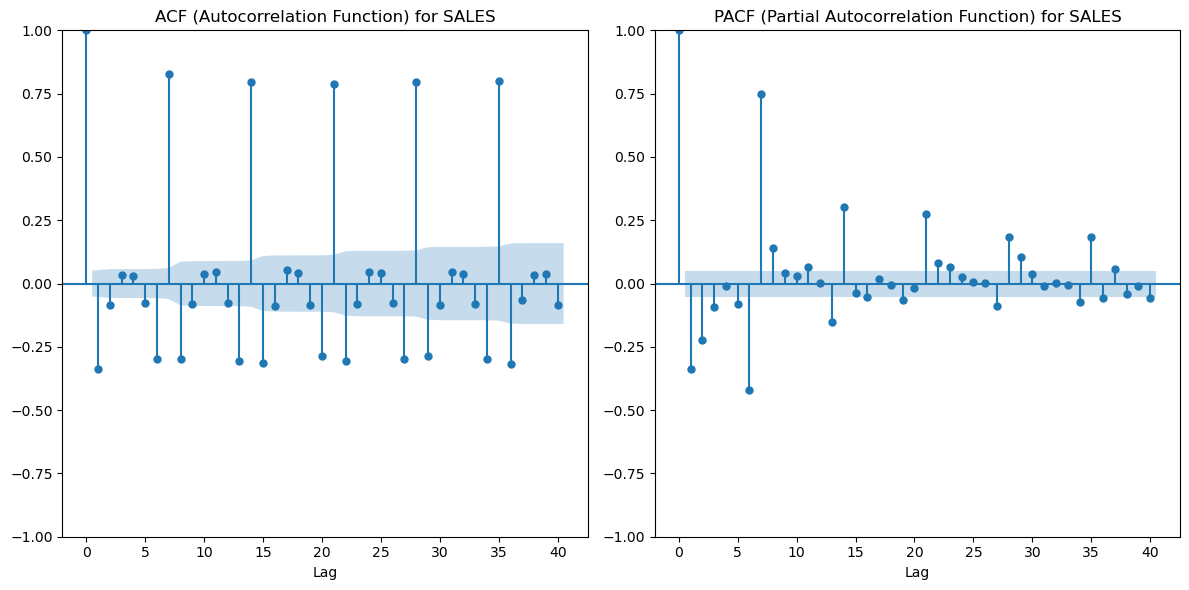

In [82]:
plot_acf_pacf(sales_lag_df['SALES'], title_suffix='for SALES')

### 3.3 LSTM (Long Short-Term Memory Neural Networks)

Implement this type of RNN for time series forescasting. 

In [30]:
X = sales_lag_df[features].values
y = sales_lag_df['SALES'].values

# Splitting data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

for train_index, test_index in tscv.split(X):
    # Splitting the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Scale the features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Scale the target variable (reshape y for scaling)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
    
    # Reshape the input data to 3D (samples, timesteps, features) for LSTM
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train_lstm, y_train_scaled, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    y_pred_scaled = model.predict(X_test_lstm)

    # Inverse transform the predictions and actuals to get them back to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_scaled)

    # Calculate the MSE
    mse = mean_squared_error(y_test_actual, y_pred)
    print(f"Mean Squared Error: {mse}")


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


2024-10-17 19:08:07.773785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.9618
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0929
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9641
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0994
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8274
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8681
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6308
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5443
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3879
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2451
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2163
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1658
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1578
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1644
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1338
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.9442
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9287
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9340
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7077
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4136
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2458
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2104
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1835
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1644
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1513
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1457
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1406
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1473
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1455
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1259
Epoch 16/20
16/

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.9171
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8853
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7092
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2556
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2152
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1531
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1357
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1424
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1360
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1519
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1591
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1430
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1092
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1304
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1025
Epoch 16/20
23/

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.9935
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9513
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5028
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1883
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1789
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1420
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1334
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1440
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1448
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1280
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1142
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1227
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0988
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0938
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0813
Epoch 16/20
31/

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9763
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7122
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2028
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1604
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1502
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1313
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1338
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1106
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1061
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1052
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0914
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0981
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1017
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0827
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0872
Epoch 16/20
38/

**Note:** Due to time limitations I could not dive deeper into the 

Let's select a model to proceed with the exercise. I will choose the ARIMA model without detrending, as it simplifies the process by eliminating the need to reverse the differencing step to recover the original `SALES` values. This makes the prediction process more straightforward compared to a detrended model, where such post-processing would be required.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


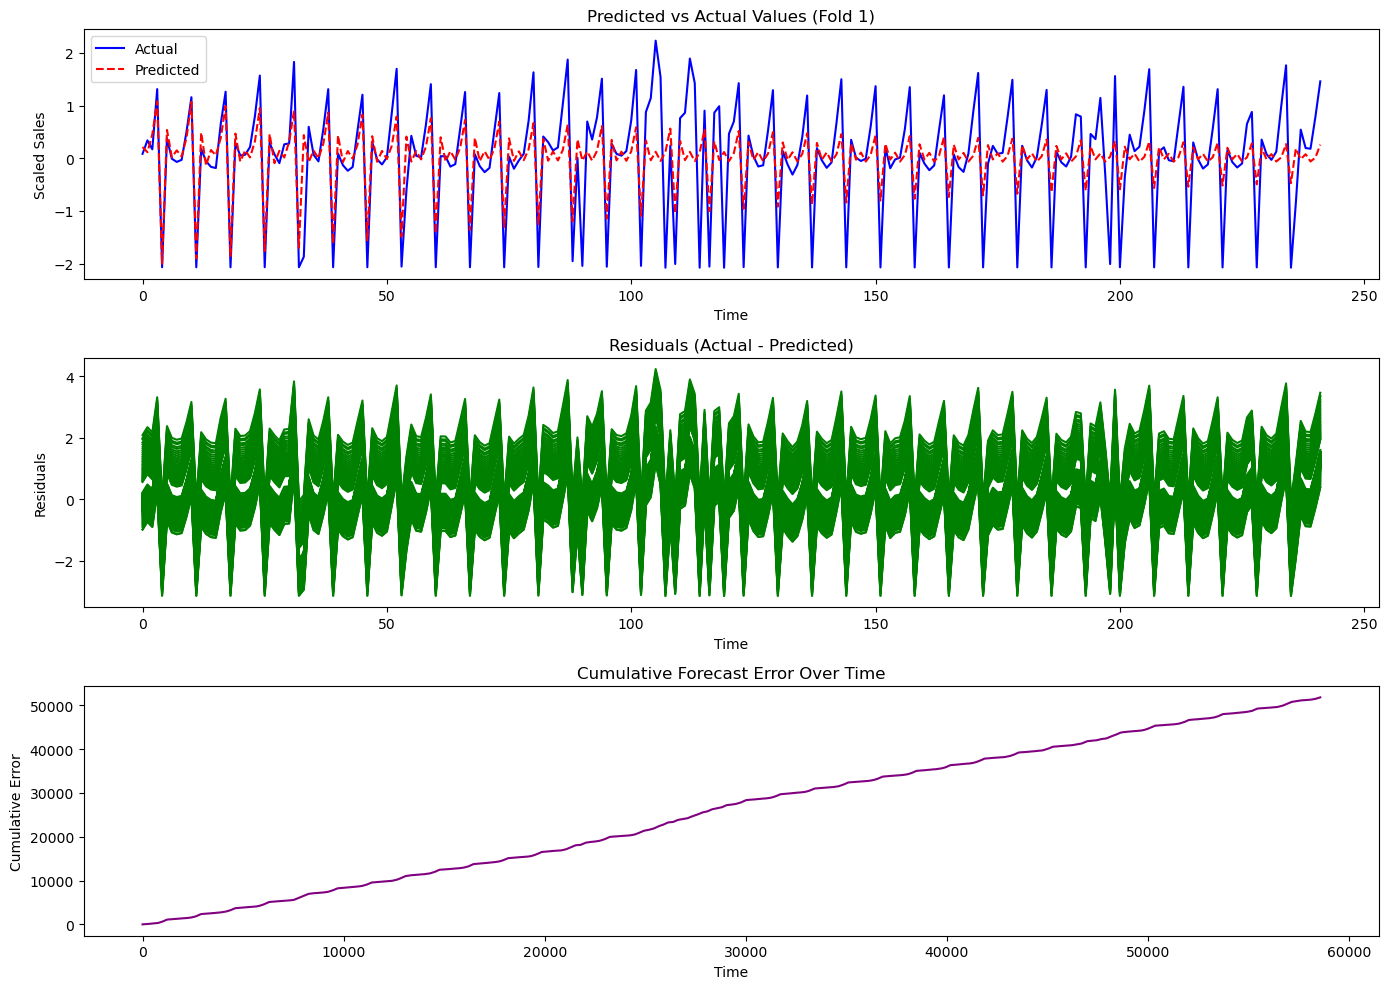

In [61]:
p = 14
d = 3
q = 0

tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()


actual_values = []
predicted_values = []
residuals_list = []
cumulative_error_list = []

plt.figure(figsize=(14, 10))

model_arima = None

for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    # Build and fit the ARIMA model
    model_arima = ARIMA(y_train_scaled, order=(p, q, d))  
    model_fit = model_arima.fit()

    # Forecast directly on the scaled data
    y_pred_scaled = model_fit.forecast(steps=len(y_test_scaled))

    # Append actual and predicted values for plotting
    actual_values.extend(y_test_scaled)
    predicted_values.extend(y_pred_scaled)

    # Calculate residuals and cumulative error
    residuals = y_test_scaled - y_pred_scaled
    residuals_list.extend(residuals)
    cumulative_error = np.cumsum(np.abs(residuals))
    cumulative_error_list.extend(cumulative_error)

    plt.clf()

    # Plot 1: Predicted vs Actual
    plt.subplot(3, 1, 1)
    plt.plot(actual_values, label='Actual', color='blue')
    plt.plot(predicted_values, label='Predicted', color='red', linestyle='--')
    plt.title('Predicted vs Actual Values (Fold {})'.format(fold))
    plt.xlabel('Time')
    plt.ylabel('Scaled Sales')
    plt.legend()

    # Plot 2: Residuals
    plt.subplot(3, 1, 2)
    plt.plot(residuals_list, color='green', label='Residuals')
    plt.title('Residuals (Actual - Predicted)')
    plt.xlabel('Time')
    plt.ylabel('Residuals')

    # Plot 3: Cumulative Forecast Error
    plt.subplot(3, 1, 3)
    plt.plot(cumulative_error_list, color='purple', label='Cumulative Error')
    plt.title('Cumulative Forecast Error Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Error')

    plt.tight_layout()
    plt.pause(0.01)  # Pause to allow the plot to update
    
    break 

# Final plot
plt.show()

By analyzing the "Predicted vs Actual Values" plot from the first fold, we observe that while our (suboptimal) ARIMA model captures the general trend of the time series, it smooths out some of the sharper peaks and troughs in the actual data. This suggests potential underfitting, particularly for the rapid changes in the true distribution. This behavior is typical in ARIMA models, which are designed to capture the smoother aspects of a series rather than sharp fluctuations.

The residual plot also reflects this issue, as the residuals exhibit a similar pattern to the spikes in the true data. Ideally, residuals should resemble white noise—random, with no discernible pattern—if the model is effectively capturing the underlying dynamics. The visible pattern in the residuals implies the model is failing to account for some important features.

It is also apparent that the ARIMA model is not effectively capturing certain types of seasonality in the data.

Regarding the "Cumulative Forecast Error Over Time" plot, the steady linear increase indicates that errors are accumulating at a consistent rate, which is expected. However, this trend suggests that the model's forecasting accuracy does not improve over time.

To address these issues, refining the model further or exploring more advanced techniques, such as SARIMA, may improve performance, particularly for capturing seasonality and rapid fluctuations.

## 4. ✅ Validation

Decide what metric to use to validate the performance of your model and explain why you chose it.

#### Key Metrics for Regression Models:
- **MAE (Mean Absolute Error):** Measures the average absolute error, making it intuitive and in the same units as the data. It treats all errors equally and is less sensitive to outliers. In our case, since the data units where so large, I used a scaling to derive the MAE.

- **MSE (Mean Squared Error) and RMSE (Root Mean Squared Error):** MSE penalizes larger errors more by squaring them, while RMSE makes the result more interpretable by converting it back to the original units. RMSE is ideal when large deviations are particularly undesirable.
- **MAPE (Mean Absolute Percentage Error):** Expresses errors as a percentage, useful for understanding relative accuracy. However, it can distort results when actual values approach zero.

#### Metric Choice:
- **RMSE** is often chosen when reducing large errors is important, such as in time series forecasting, as it penalizes significant deviations.
- **MAE** provides a straightforward measure of average error and is preferred when interpretation and robustness to outliers are priorities.
- **MAPE** is ideal when relative accuracy is critical, though it should be used cautiously when actual values are small.

The right metric should align with the goals of the problem and the data characteristics to ensure accurate evaluation and model improvement.

The metrics are presented above.

**Note:** I would like to compare the diffent folds within the model in toder to check that they have a similar behavour. This is important to ensure that all folds can generalise well.

## 5. 📊 Presentation of Results

If you find it interesting, you can use plots to explain your results, metrics and how your model performance degrades over time.

Also, it may be interesting to write down future work that you think may improve the obtained result.

**Note:** Find the control plots in the exercise above.

![metrics](figure.png)


**Note:** At this point, several optimizations and refinements are still necessary to improve the model's accuracy. I consider the results produced by the current model to be unsatisfactory.

**Note:** Within the future work, I would like to further explore the LSTM approach and, specially, the SARIMA model.

**Note:** It would be beneficial to explore data augmentation techniques, even though they are more commonly applied in fields like NLP or computer vision. Data augmentation can still be effectively utilized in time series forecasting. Techniques such as time warping and time series jittering are particularly useful for introducing variability while preserving temporal structure. These methods can be implemented using functions like `interp1d` from the `scipy.interpolate` module, enabling the generation of diverse training samples to enhance model robustness



### 5.1 👨🏻‍🏫 Explainability with SHAP

You have explained the results of your trained model using plots and your own words. Now... let's take the next step. We'll be using a library called SHAP, that may help you find insights and explainability on how your model learned the data.

If you haven't heard of SHAP you can find their web site here:

https://shap.readthedocs.io/en/latest/

Don't worry, you will be guided through this exercises.

**Note**: It appears that using SHAP with ARIMA models is not supported. SHAP is designed for machine learning models and expects a "callable" function, such as `predict` or `predict_proba`, which statistical models like ARIMA do not provide. This limitation has been discussed in the SHAP GitHub community. For more details, see the discussion [here](https://github.com/shap/shap/discussions/1464).

#### 5.1.1 🐝 Build a Beeswarm plot

Build a Beeswarm plot to help you explain how each feature affects to the output given by the model

In [ ]:
explainer = shap.Explainer(model_arima, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

#### 5.1.2 💪🏻 Build a Force plot

Build a Force plot to help you explain how each feature affects to the output given by the model

In [ ]:
shap_values_single = explainer(X_train.iloc[0, :])
shap.plots.force(shap_values_single)
shap_values_all = explainer(X_train[:100])  # First 100 predictions
shap.plots.force(shap_values_all)

plt.show()

#### 5.1.3 🤷🏻‍♂️ Optional

Explore the SHAP documentation and add any plot you may find useful to explain how the model decides its outputs.

In [ ]:
shap.summary_plot(shap_values, X_train)

## 6. 🗃️ Model export

If you have arrived to this point... Congratulations!! 🥳. You trained a working model that can now be served in an API to be used to make predictions.

If you feel like developing a simple REST API to serve your amazing model, continue to the next step you will find in the `app/main.py` file located in this repository.

But first, make sure to export your model to a file you can use to load it in your endpoint.

In [52]:
with open('../data/model_arima.pkl', 'wb') as model_file:
    pickle.dump(model_arima, model_file)

print("ARIMA model has been saved to 'model_arima.pkl'")

ARIMA model has been saved to 'model_arima.pkl'
